In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc
import pathlib as pt
import numpy as np
import sys
import os

import sys
scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

f,_ = sf.makeOutoutFolders()
sf.nbInit(f)

pd.set_option('display.max_columns', 100)
print(sys.version)

3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 16:01:55) 
[GCC 11.3.0]


In [ ]:
# THRESH 
FDR_THRESH = 0.05
LOGFC_THRESH = 0.2
MIN_GENES_THRESH = 20
MIN_PER_THRESH = 10

FDRstr = str(FDR_THRESH).replace('.','')
LOGFCstr = str(LOGFC_THRESH).replace('.','')
MIN_GENESstr = str(MIN_GENES_THRESH)
MIN_PERstr = str(MIN_PER_THRESH)

In [3]:
# load and filter data
adata = sc.read('../../../workingObj/cdata_all_T21vs2n.h5ad')
metadata = pd.read_csv('../cpdh_input_T21_vs_2n/cdata_all_MATCHING_metadata_p1Luz.tsv', sep = '\t')


# update '-' to '_'
adata.obs['celltype'] = adata.obs['celltype'].replace({'thy_Lumen-forming' : 'thy_Lumen_forming', 'epi_HLA-B' : 'epi_HLA_B'})
# filter adata to include cells from metadata only
adata = adata[adata.obs.index.isin(metadata['index'].unique())]
# make cell_labels column
adata.obs['cell_labels'] = adata.obs['celltype'].astype(str)+'.'+adata.obs['karyotype'].astype(str)
print(set(adata.obs['cell_labels']))

/tmp/ipykernel_7471/3575142930.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_labels'] = adata.obs['celltype'].astype(str)+'.'+adata.obs['karyotype'].astype(str)


{'end_Arterial.2n', 'end_Capillary.T21', 'thy_Lumen_forming.T21', 'thy_TH_processing.2n', 'mes_CYGB.T21', 'end_Lymphatic.T21', 'end_Venous.T21', 'end_Lymphatic.2n', 'end_Arterial.T21', 'end_Venous.2n', 'mes_CYGB.2n', 'thy_TH_processing.T21', 'end_Capillary.2n', 'thy_Lumen_forming.2n'}


In [4]:
# load cpdb output files
means                 = pd.read_table(pt.Path().absolute().parent / 'cpdh_output_T21_vs_2n' / f'degs_analysis_means_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.txt')
relevant_interactions = pd.read_table(pt.Path().absolute().parent / 'cpdh_output_T21_vs_2n' / f'degs_analysis_relevant_interactions_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.txt')
interaction_scores    = pd.read_table(pt.Path().absolute().parent / 'cpdh_output_T21_vs_2n' / f'degs_analysis_interaction_scores_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.txt')
deconvoluted          = pd.read_table(pt.Path().absolute().parent / 'cpdh_output_T21_vs_2n' / f'degs_analysis_deconvoluted_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.txt')

# make cpdb_results dict 
cpdb_results={}
cpdb_results['means'] = means
cpdb_results['relevant_interactions'] = relevant_interactions
cpdb_results['interaction_scores'] = interaction_scores
cpdb_results['deconvoluted'] = deconvoluted

### Explore CellphoneDB results

In [6]:
# -- Get annotation columns and interactions 
annotation = list(cpdb_results['relevant_interactions'].columns[:13])
interaction = list(cpdb_results['relevant_interactions'].columns[13:])


# -- Convert relevant_interactions file from wide to long
relevant_interactions_long = pd.melt(cpdb_results['relevant_interactions'],
                                     id_vars = annotation,
                                     var_name = 'Interacting_cell',
                                     value_vars = interaction,
                                     value_name = 'Relevance')

relevant_interactions_long[['Cell_a', 'Cell_b']] = relevant_interactions_long['Interacting_cell'] \
    .str.split('|', expand = True) \
    .rename(columns={0 : 'Cell_a', 1: 'Cell_b'})

relevant_interactions_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance,Cell_a,Cell_b
0,CPI-SC04BD52124,COL18A1_integrin_a2b1_complex,simple:P39060,complex:integrin_a2b1_complex,COL18A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|thy_TH_processing.T21,1,thy_TH_processing.T21,thy_TH_processing.T21
1,CPI-SC0CCB0D955,COL6A1_integrin_a2b1_complex,simple:P12109,complex:integrin_a2b1_complex,COL6A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|thy_TH_processing.T21,1,thy_TH_processing.T21,thy_TH_processing.T21
2,CPI-SC0C739EDCE,COL18A1_integrin_a1b1_complex,simple:P39060,complex:integrin_a1b1_complex,COL18A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|thy_TH_processing.T21,0,thy_TH_processing.T21,thy_TH_processing.T21


In [7]:
# -- Convert means file from wide to long
means_long = pd.melt(cpdb_results['means'],
                     id_vars = annotation,
                     var_name = 'Interacting_cell',
                     value_vars = interaction,
                     value_name = 'Mean')

means_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Mean
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,thy_TH_processing.T21|thy_TH_processing.T21,0.729
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|thy_TH_processing.T21,0.065
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|thy_TH_processing.T21,0.064


## Sort interaction by recurrence

To facilitate the selection of interactions of interest we will calculate the recurrence of each interaction (i.e. number of times an interaction appears as relevant across all interacting partners). Here, we assume that we are interested in interactions that are specific (i.e. interactions found between a limited number of cells). This table  with the help of prior knowledge, corroborations with other dataset (i.e visium, imaging ...) select/validate the most relevant interactions.

In [8]:
# -- Create a dictionary with recurrence of relevance of any give interaction
id_cp_dict = relevant_interactions_long.groupby('id_cp_interaction')['Relevance'] \
    .sum() \
    .to_dict()

# -- Add new column to indicante the recurrence of an interaction
relevant_interactions_long['Recurrence'] = relevant_interactions_long['id_cp_interaction'] \
    .map(id_cp_dict)

# -- Sort according to the recurrence
relevant_interactions_long = relevant_interactions_long.sort_values(['Recurrence'],
                                                                    ascending = True)

relevant_interactions_long.head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance,Cell_a,Cell_b,Recurrence
78,CPI-SC0755F1632,COL18A1_integrin_a11b1_complex,simple:P39060,complex:integrin_a11b1_complex,COL18A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|mes_CYGB.T21,1,thy_TH_processing.T21,mes_CYGB.T21,2
31,CPI-SC0FB1817EE,COL6A1_integrin_a11b1_complex,simple:P12109,complex:integrin_a11b1_complex,COL6A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_TH_processing.T21|end_Venous.T21,0,thy_TH_processing.T21,end_Venous.T21,2
90,CPI-SC0755F1632,COL18A1_integrin_a11b1_complex,simple:P39060,complex:integrin_a11b1_complex,COL18A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,thy_Lumen_forming.T21|thy_TH_processing.T21,0,thy_Lumen_forming.T21,thy_TH_processing.T21,2


Based on our own knowledge and corroboration with experimental data we have select a set of interactions with the following ids.

In [9]:
relevant_interactions_plot = relevant_interactions_long.copy()

Alternatively, we can make use of of Kelvin's implementations ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellphoneDB outputs. In this example we will plot the interactions between PVs and the trophoblasts that are mediated by TGFB2 and CSF1R.

In [10]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

# plot all interactions

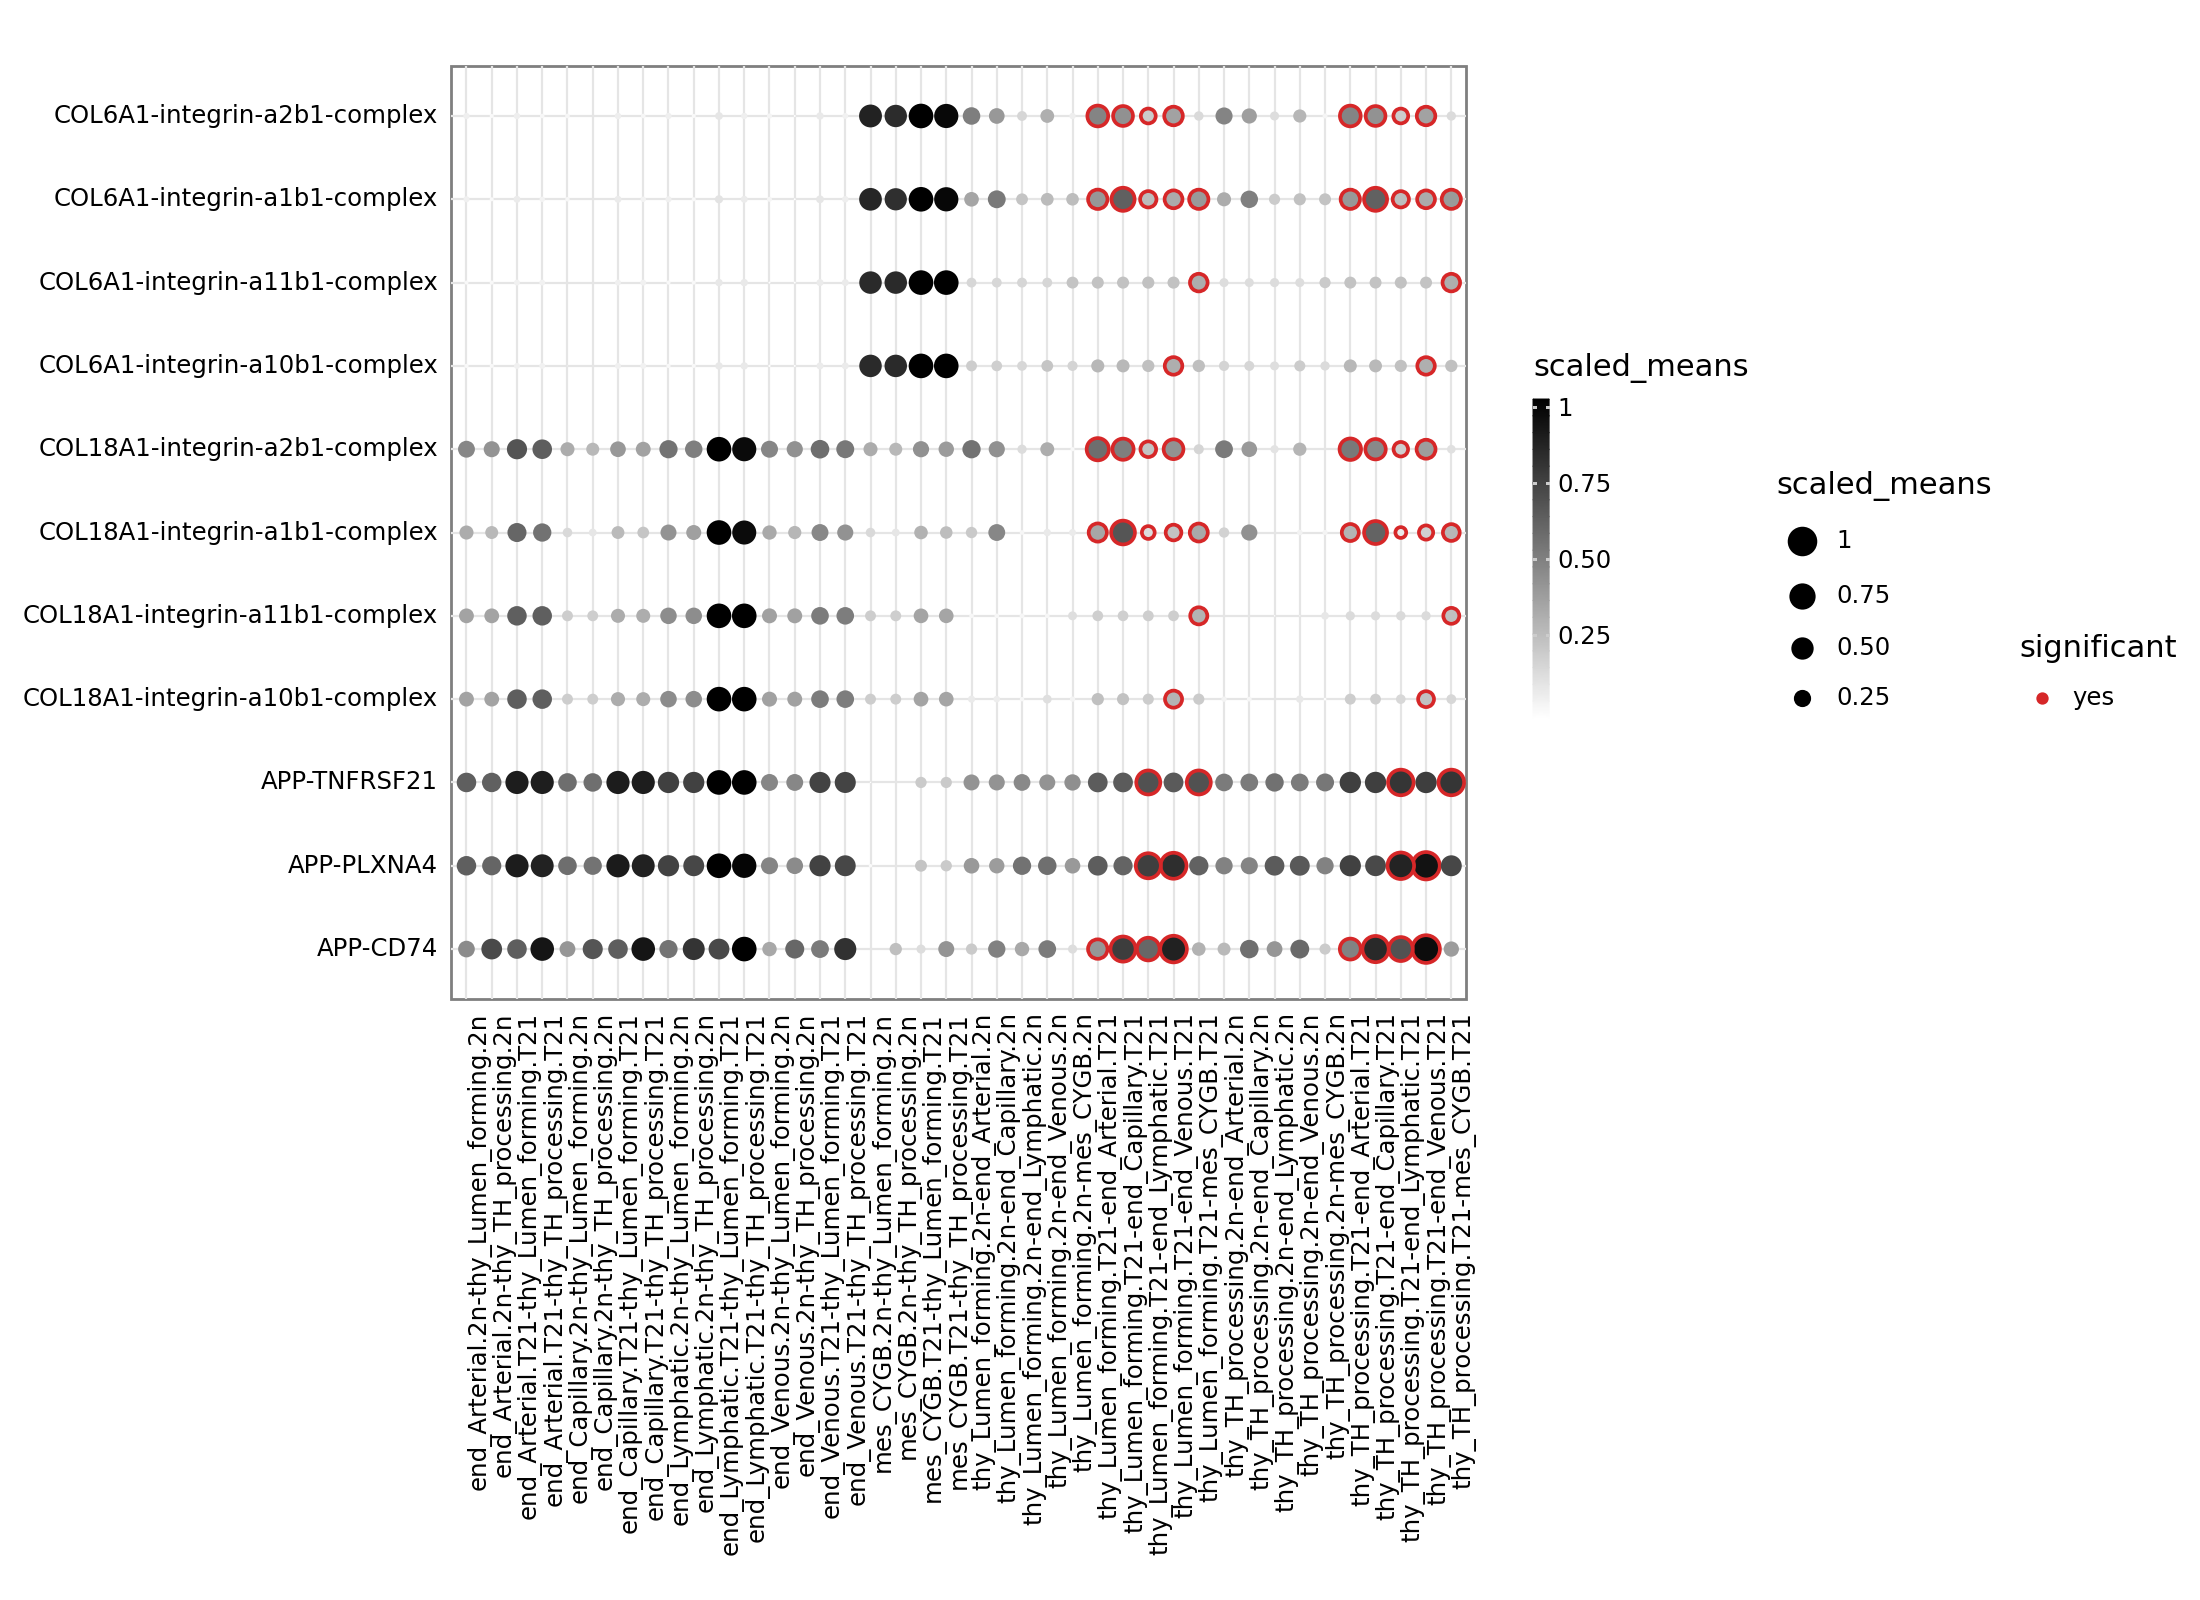

<Figure Size: (1100 x 800)>

In [11]:
from plotnine import facet_wrap
with plt.rc_context({'font.size': 2}):
    p1 = kpy.plot_cpdb(
        adata = adata,
        cell_type1 = 'thy_Lumen_forming.2n|thy_Lumen_forming.T21|thy_TH_processing.2n|thy_TH_processing.T21',
        cell_type2 = 'end_Arterial.2n|end_Arterial.T21|end_Capillary.2n|end_Capillary.T21|end_Lymphatic.2n|end_Lymphatic.T21|end_Venous.2n|end_Venous.T21|mes_CYGB.2n|mes_CYGB.T21',
        means = cpdb_results['means'],
        pvals = cpdb_results['relevant_interactions'],
        celltype_key = "cell_labels",
        figsize = (11,8),
    #     title = "Interactions with ligans expressed by thyrocytes cells",
        max_size = 5,
        cmap_name = 'gray_r',
        highlight_size = 0.75,
        degs_analysis = True,
        standard_scale = True,
    )
p1

In [12]:
p1.save(f'./figures/all_interactions_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.pdf')

/home/jovyan/my-conda-envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 11 x 8 in image.
/home/jovyan/my-conda-envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./figures/all_interactions_mergeMi_20min_10per_p_val_adj_005_avg_log2FC_02Luz.pdf


## get genes located on chr21

In [13]:
def addChrInfo(plot):
    from itertools import chain

    def remove_lowercase(s):
        return ''.join(char for char in s if not char.islower())

    def process_list_of_lists(list_of_lists):
        # Remove small case letters from each string in the list of lists
        processed_lists = [[remove_lowercase(s) for s in sublist] for sublist in list_of_lists]

        # Flatten the list of lists
        flattened_list = list(chain.from_iterable(processed_lists))

        # Get unique elements
        unique_elements = list(set(flattened_list))

        return unique_elements

    # Example usage
    list_of_lists = plot.data['interaction_group'].str.split('-').tolist()

    result = process_list_of_lists(list_of_lists)

    # get genes in adata
    result = adata.var_names[adata.var_names.isin(result)]

    # get chr 
    result = sf.addChrInfo(pd.DataFrame(index=result))
    return result

In [15]:
# focuse on thySender genes
substr = ('thy_Lumen_forming.2n','thy_Lumen_forming.T21','thy_TH_processing.2n','thy_TH_processing.T21')

# relevant_interactions
df = cpdb_results['relevant_interactions']
celltype_cols = [s for s in df.columns if '|' in s]
const_cols = [s for s in df.columns if not '|' in s]
new_cols = [s for s in celltype_cols if s.startswith(substr) & ~s.endswith(substr)]
cpdb_results['NEW_relevant_interactions'] = df[const_cols + new_cols]

# means
df = cpdb_results['means']
celltype_cols = [s for s in df.columns if '|' in s]
const_cols = [s for s in df.columns if not '|' in s]
new_cols = [s for s in celltype_cols if s.startswith(substr) & ~s.endswith(substr)]
cpdb_results['NEW_means'] = df[const_cols + new_cols]

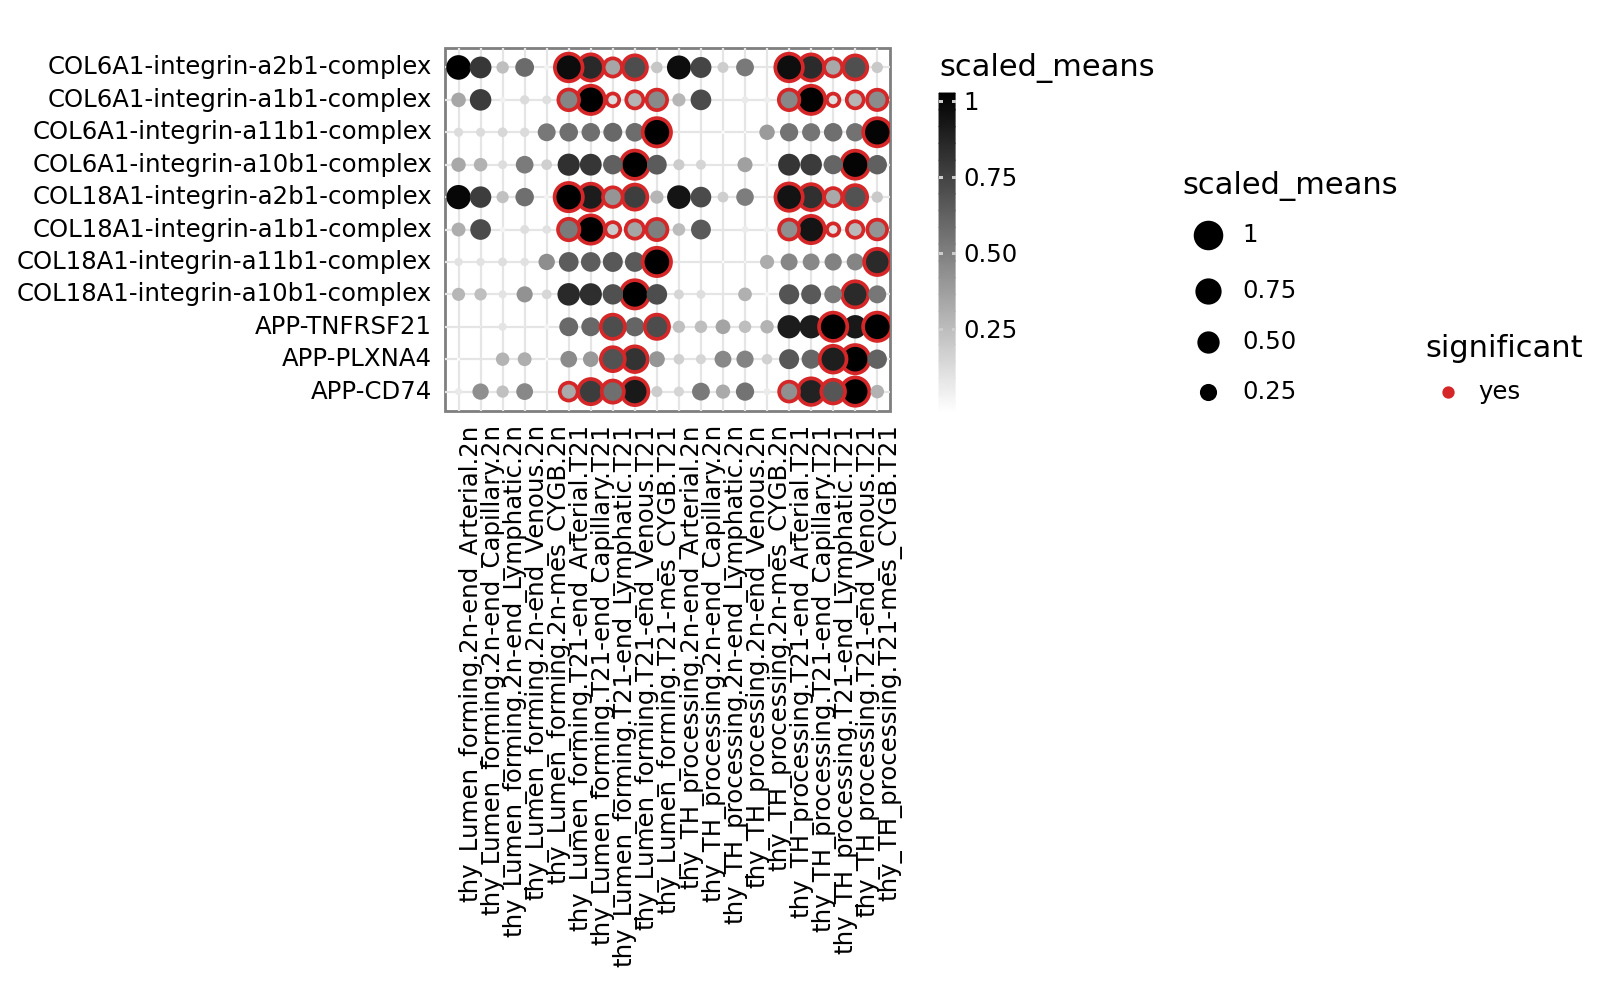

<Figure Size: (800 x 500)>

In [ ]:
from plotnine import facet_wrap
# with plt.rc_context({'font.size': 2}):
p21_BMP = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = 'thy_Lumen_forming.2n|thy_Lumen_forming.T21|thy_TH_processing.2n|thy_TH_processing.T21',
    cell_type2 = 'end_Arterial.2n|end_Arterial.T21|end_Capillary.2n|end_Capillary.T21|end_Lymphatic.2n|end_Lymphatic.T21|end_Venous.2n|end_Venous.T21|mes_CYGB.2n|mes_CYGB.T21',
    means = cpdb_results['NEW_means'],
    pvals = cpdb_results['NEW_relevant_interactions'],
    celltype_key = "cell_labels",
    genes = ["COL18A1|COL6A1|APP"],
    figsize = (8,5), #3.5,3
    max_size = 5,
    cmap_name = 'gray_r',
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
)
p21_

In [ ]:
p21_.save(f'./figures/thySender_mergeMi_{MIN_GENESstr}min_{MIN_PERstr}per_p_val_adj_{FDRstr}_avg_log2FC_{LOGFCstr}Luz.pdf')

/home/jovyan/my-conda-envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/jovyan/my-conda-envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./figures/thySender_mergeMi_20min_10per_p_val_adj_005_avg_log2FC_02Luz.pdf
